# How to Access GES DISC Data Using Python

<p></p>

<div style="background:#FFFFC5; border:1px solid #000000; padding:5px 10px; color:#000000;">
    Please, be very judicious when working on long data time series residing on a remote data server.<br />
    It is very likely that attempts to apply similar approaches on remote data, such as hourly data, for more than a year of data at a time, will result in a heavy load on the remote data server. This may lead to negative consequences, ranging from very slow performance that will be experienced by hundreds of other users, up to denial of service.
</div>

### Overview

There are multiple ways to work with GES DISC data resources using Python. For example, the data can accessed using [techniques that rely on a native Python code](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html). 

Still, there are several third-party libraries that can further simplify the access. In the sections below, we demonstrate downloading and streaming granules to the notebook using these libraries.

The examples will use a sample MERRA-2 granule, from the [M2T1NXSLV.5.12.4 collection](https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=M2T1NXSLV_5.12.4), to demonstrate data access.

### Prerequisites

<div style="background:#ADD8E6; border:1px solid #000000; padding:5px 10px; color:#000000;">
    <strong>Warning:</strong> An Earthdata Login account with the "NASA GES DISC DATA ARCHIVE" and "Hyrax in the Cloud" applications enabled are required to access GES DISC data and store "Earthdata prerequisite files". To create an Earthdata Login account, and enable these applications, please visit <a href="https://disc.gsfc.nasa.gov/earthdata-login" target="_blank">this guide</a>.
</div>

This notebook was written using Python 3.10, and requires these libraries and files:

- `netrc` or `edl_token` file with valid Earthdata Login credentials
   - [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)
- [requests](https://docs.python-requests.org/en/latest/) (version 2.22.0 or later)
- [pydap](https://github.com/pydap/pydap) (we recommend using version 3.5)
- [xarray](https://docs.xarray.dev/en/stable/)
- [netCDF4-python](https://github.com/Unidata/netcdf4-python) (we recommend using version 1.6.2)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/quick-start/)
- ***Optional:***
   - For OPeNDAP examples, this notebook can be run using the ['opendap' YAML file](https://github.com/nasa/gesdisc-tutorials/tree/main/environments/opendap.yml) provided in the 'environments' subfolder. Please follow the instructions [here](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) to install and activate this environment.
 

### Contents
* [Download Full Granule Data](#download_full_granules)
    * [Option 1: Use `requests`](#download_requests)
    * [Option 2: Use `earthaccess`](#download_earthaccess)
* [Stream Full Granule Data](#stream_full_granules)

* [Subset and Stream Granule Data from OPeNDAP Servers](#opendap)
    * [Option 1a: Use `pydap` with Earthdata Login credentials ](#opendap_pydap)
    * [Option 1b: Use `pydap` with Earthdata Login credentials ](#opendap_pydap_token)
    * [Option 2: Use `xarray`](#opendap_xarray)
    * [Option 3: Use `netcdf4-python`](#opendap_netcdf4-python)
* [Subset and Stream Granule Data from THREDDS Servers](#thredds)
    * [Option 1: Use `xarray`](#thredds_xarray)
* [Subset and Stream Data from the Level 3/4 Subsetter and Regridder API](#l34rs)

### Links Used in this Notebook

There are several example links that will be used to access data from the same granule. Each link can be searched for using several tools, including [Earthdata Search](https://search.earthdata.nasa.gov/search/granules/granule-details?p=C1276812863-GES_DISC&pg[0][v]=f&pg[0][qt]=1980-01-01%2C1981&pg[0][gsk]=-start_date&g=G1277898447-GES_DISC&q=M2T1NXSLV&tl=1723660883!3!!), the [dataset landing page](https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=M2T1NXSLV_5.12.4) for the particular collection, or through the [Content Metadata Repository](https://cmr.earthdata.nasa.gov/virtual-directory/collections/C1276812863-GES_DISC/temporal/1980/01/01). Links can be generated programmatically using the `earthaccess` library, the [python-cmr](https://github.com/nasa/python_cmr) library, or the [Web Services API](https://disc.gsfc.nasa.gov/information/howto?keywords=dataset%).

Links used in this notebook:
- HTTPS: https://data.gesdisc.earthdata.nasa.gov/data/MERRA2/M2T1NXSLV.5.12.4/1980/01/MERRA2_100.tavg1_2d_slv_Nx.19800101.nc4
- OPeNDAP ([?](https://disc.gsfc.nasa.gov/information/documents?title=OPeNDAP%20In%20The%20Cloud)): 
    - OPeNDAP Subsetting Page: https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4.dmr.html
    - Example OPeNDAP URL (No Subsetting): https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4
    - Example OPeNDAP URL (With variable subset): https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4?dap4.ce=/T2M[0:1:23][0:1:360][0:1:575]
- THREDDS ([?](https://docs.unidata.ucar.edu/tds/4.6/adminguide/#:~:text=Overview,other%20remote%20data%20access%20protocols.)): 
    - Example THREDDS URL Subsetting Page: https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXSLV.5.12.4/M2T1NXSLV.5.12.4_Aggregation_1980.ncml.html
    - Example THREDDS URL (for `Xarray` access only): https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXSLV.5.12.4/M2T1NXSLV.5.12.4_Aggregation_1980.ncml


---



### Download Full Granule Data <a class="anchor" id="download_full_granules"></a>

#### Option 1: Use `requests` <a class="anchor" id="download_requests"></a>

`requests` is a popular Python library that simplifies Python access to Internet-based resources. In the following code, we demonstrate how to use 'Requests' to access GES DISC data using cookies created by a host operating system.

In [1]:
import requests

URL = 'https://data.gesdisc.earthdata.nasa.gov/data/MERRA2/M2T1NXSLV.5.12.4/1980/01/MERRA2_100.tavg1_2d_slv_Nx.19800101.nc4'

# Set the FILENAME string to the data file name, the LABEL keyword value, or any customized name. 
# Remember to include the same file extension as in the URL.
FILENAME = 'MERRA2_100.tavg1_2d_slv_Nx.19800101.nc4'

result = requests.get(URL)
try:
    result.raise_for_status()
    f = open(FILENAME,'wb')
    f.write(result.content)
    f.close()
    print('contents of URL written to '+FILENAME)
except:
    print('requests.get() returned an error code '+str(result.status_code))
    

contents of URL written to MERRA2_100.tavg1_2d_slv_Nx.19800101.nc4


#### Option 2: Use `earthaccess`  <a class="anchor" id="download_earthaccess"></a>

The `earthaccess` library can be used to search for granules and download them to your local machine, based on the collection shortname, longname, version, or DOI, gathered from the collection dataset landing page or the Content Metadata Repository. The `search_data` function will search for granules inside the specified temporal and bounding box ranges, and will return a list of URLs to be downloaded. Finally, it will download these URLs, assuming you have been authenticated using your previously-generated Earthdata prerequisite files.

Please note that as of August 2024, `earthaccess` does not have the ability to return OPeNDAP URLs.

In [2]:
import earthaccess

# This will work if Earthdata prerequisite files have already been generated
auth = earthaccess.login()

# To download multiple files, change the second temporal parameter
results = earthaccess.search_data(
    doi="10.5067/VJAFPLI1CSIV",
    temporal=('1980-01-01', '1980-01-01'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(-180, 0, 180, 90)
)

downloaded_files = earthaccess.download(
    results,
    local_path='.', # Change this string to download to a different path
)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

### Stream One or More Granules Using Python <a class="anchor" id="stream_full_granules"></a>

The `earthaccess` library has the ability to "stream" the full data of a granule, or multiple granules, to an Xarray dataset object, without having to download before opening in your current notebook session. Please note that this will stream the full data and every variable of the granule to the notebook, which may take extra time and computational resources. To access one variable at a time or perform subsetting before the data is streamed to the notebook, please access data from an OPeNDAP server.

In [3]:
import earthaccess
import xarray as xr

# This will work if Earthdata prerequisite files have already been generated
auth = earthaccess.login()

# We recommend only streaming one granule at a time, as some collections can be quite large
results = earthaccess.search_data(
    doi="10.5067/VJAFPLI1CSIV",
    temporal=('1980-01-01', '1980-01-01'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(-180, 0, 180, 90)
)

fs = earthaccess.open(results) # Extracts URLs from the results variable

# The open_mfdataset() function must be used when opening one or multiple granules with earthaccess
ds = xr.open_mfdataset(fs) # Opens the two granules and concatenates them along the time dimension
ds


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:   (lon: 576, lat: 361, time: 24)
Coordinates:
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time      (time) datetime64[ns] 1980-01-01T00:30:00 ... 1980-01-01T23:30:00
Data variables: (12/47)
    CLDPRS    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    CLDTMP    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    DISPH     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H1000     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H500      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    ...        ...
    V250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V2M       (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V500      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V50M      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V850      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    ZLCL      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
Attributes: (12/30)
    History:                           Original file generated: Sat May 31 17...
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Filename:                          MERRA2_100.tavg1_2d_slv_Nx.19800101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/VJAFPLI1CSIV
    RangeBeginningDate:                1980-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   1980-01-01
    RangeEndingTime:                   23:59:59.000000

In [4]:
import earthaccess
import xarray as xr

# This will work if Earthdata prerequisite files have already been generated
auth = earthaccess.login()

# We recommend only streaming one granule at a time, as some collections can be quite large
results = earthaccess.search_data(
    doi='10.5067/VJAFPLI1CSIV',
    temporal=('1980-01-01', '1980-01-01'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(-180, 0, 180, 90)
)

fs = earthaccess.open(results) # Extracts URLs from the results variable

# The open_mfdataset() function must be used when opening one or multiple granules with earthaccess
# NOTE: When opening HDF files, the group to be accessed must be specified with the "group=" parameter. 
#       E.g., for GPM IMERG, group="Grid" must be entered or an error will occur
ds = xr.open_mfdataset(fs) 
ds

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:   (lon: 576, lat: 361, time: 24)
Coordinates:
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time      (time) datetime64[ns] 1980-01-01T00:30:00 ... 1980-01-01T23:30:00
Data variables: (12/47)
    CLDPRS    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    CLDTMP    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    DISPH     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H1000     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H500      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    ...        ...
    V250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V2M       (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V500      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V50M      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V850      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    ZLCL      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
Attributes: (12/30)
    History:                           Original file generated: Sat May 31 17...
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Filename:                          MERRA2_100.tavg1_2d_slv_Nx.19800101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/VJAFPLI1CSIV
    RangeBeginningDate:                1980-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   1980-01-01
    RangeEndingTime:                   23:59:59.000000

### Subset and Stream Granule Data From OPeNDAP Servers <a class="anchor" id="opendap"></a>

Rather than having to download or stream an entire granule, you can access data from an OPeNDAP server, which will allow you to view dataset metadata and subset single or multiple varibles before its data is streamed to the current notebook session.

#### Option 1a: Use `pydap` with Earthdata Login Credentials  <a class="anchor" id="opendap_pydap"></a>

A convenient way to access GES DISC OPeNDAP resources can be achieved with `Pydap`, a Python library that both provides an interface for Python programs to read from OPeNDAP servers and the netCDF4 Python module which uses the netCDF-C library to actually access data. The examples below uses a MERRA-2 Cloud OPeNDAP-enabled URL, denoted by its "opendap.earthdata.nasa.gov" address. Because of this, the `pydap` library requires we specify `protocol="dap4"` in the `open_url()` function, which will allow for faster data access. When accessing OPeNDAP URLs from non-Cloud OPeNDAP-enabled URLs, the protocol parameter can be set to `protocol="dap2"`. Additionally, the `pydap` library allows users to directly enter their 

For more information about Cloud OPeNDAP, please visit this document [here](https://disc.gsfc.nasa.gov/information/documents?keywords=opendap&title=OPeNDAP%20In%20The%20Cloud).


In [5]:
from pydap.client import open_url
from pydap.cas.urs import setup_session
import getpass

# Specify 1980-01-01 Cloud OPeNDAP URL with T2M subsetting
dataset_url = 'https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4?dap4.ce=/T2M[0:1:23][0:1:360][0:1:575]'

# Prompts for entering Earthdata login credentials
prompts = [
    'Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
    'Enter NASA Earthdata Login Password: '
]

username = input(prompts[0])
password = getpass.getpass(prompts[1])

# Stream the granule into a "dataset" variable
try:
    session = setup_session(username, password, check_url=dataset_url)
    dataset = open_url(dataset_url, session=session, protocol="dap4")
    print(dataset['T2M']) # Select a variable and view its data
except AttributeError as e:
    print('Error:', e)
    print('Please verify that the dataset URL points to an OPeNDAP server, the OPeNDAP server is accessible, or that your username and password are correct.')

<BaseType with data Dap4BaseProxy('http://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4', 'T2M', dtype('>f4'), (24, 361, 576), (slice(0, 24, 1), slice(0, 361, 1), slice(0, 576, 1)))>


#### Option 1b: Use `pydap` with stored Earthdata Login Token  <a class="anchor" id="opendap_pydap_token"></a>

If you have a `.edl_token` file stored, you can use the `Pydap` library to access OPeNDAP data using the stored token. Alternatively, you can copy and paste the EDL token manually gathered from your account and set the `token` variable to a string containing your full token.

In [6]:
from pydap.client import open_url
import requests
import os

# Specify 1980-01-01 Cloud OPeNDAP URL with T2M subsetting
dataset_url = 'https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4?dap4.ce=/T2M[0:1:23][0:1:360][0:1:575]'

# Set file path to root
token_file_path = os.path.join(os.path.expanduser("~"), ".edl_token")

# Read the token from the .edl_token file
with open(token_file_path, 'r') as token_file:
    token = token_file.read().strip()  # Ensure to strip any newlines or extra spaces

# Enter the token into the request header
my_session = requests.Session()
my_session.headers={"Authorization": token}

try:
    # Open the dataset using the request session containing your token
    dataset = open_url(dataset_url, session=my_session, protocol="dap4")

    # Stream and display the values of the 2-meter temperature variable
    print(dataset['T2M'][:])
except OSError as e:
    print('Error', e)
    print('Please check that your .dodsrc files are in their correct locations, or that your .netrc file has the correct username and password.')

<BaseType with data array([[[244.07703, 244.07703, 244.07703, ..., 244.07703, 244.07703,
         244.07703],
        [244.01453, 244.02234, 244.03015, ..., 243.99109, 243.9989 ,
         244.00671],
        [244.55359, 244.5614 , 244.57703, ..., 244.52234, 244.53015,
         244.54578],
        ...,
        [253.21375, 253.22156, 253.22937, ..., 253.19226, 253.20007,
         253.20789],
        [253.93445, 253.9364 , 253.9403 , ..., 253.92468, 253.92859,
         253.93054],
        [254.40125, 254.40125, 254.40125, ..., 254.40125, 254.40125,
         254.40125]],

       [[243.79819, 243.79819, 243.79819, ..., 243.79819, 243.79819,
         243.79819],
        [243.88412, 243.89194, 243.89975, ..., 243.85287, 243.86069,
         243.87631],
        [244.56381, 244.57944, 244.58725, ..., 244.54037, 244.54819,
         244.556  ],
        ...,
        [252.97006, 252.97787, 252.9896 , ..., 252.94272, 252.95053,
         252.96225],
        [253.75717, 253.75912, 253.76303, ..., 253.7

#### Option 2: Use `xarray` <a class="anchor" id="opendap_xarray"></a>

The `xarray` library offers a suite of various data computation, subsetting, and plotting capabilities, and can perform subsetting operations on OPeNDAP-enabled granules, as long as Earthdata prerequisite files are present and valid. The example below will stream the metadata from a full Cloud OPeNDAP-enabled MERRA-2 granule, before creating a bounding box subset request for a single variable, which will be sent to the OPeNDAP server and streamed to the notebook. Please note that this library works best with URLs that do ***not*** contain OPeNDAP subsetting syntax. For more information on these functions, see their documentation: https://docs.xarray.dev/en/stable/user-guide/indexing.html

**Warning:** When accessing data from OPeNDAP servers using `xarray`, you will experience errors if your `.dodsrc` prerequisite file is not generated and properly stored in addition to your `.netrc` file.

If you wish to save the subsetted granule locally, please use the `to_dataset` function, documented here: https://docs.xarray.dev/en/latest/generated/xarray.Dataset.to_netcdf.html


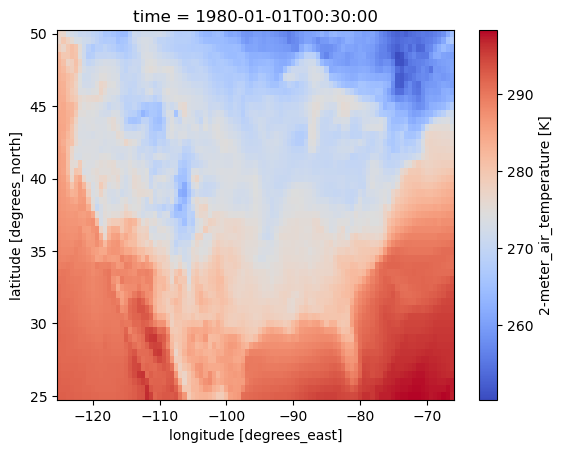

In [7]:
import xarray as xr

# Specify 1980-01-01 Cloud OPeNDAP URL
dataset_url = 'https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4'

# Load dataset object and metadata, but don't open the values yet
# NOTE: When opening HDF files, the group to be accessed must be specified with the "group=" parameter. 
#       E.g., for GPM IMERG, group="Grid" must be entered or an error will occur
ds = xr.open_dataset(dataset_url)

# Define latitude and longitude bounds for CONUS
lat_min, lat_max = 25, 50  # Latitude bounds
lon_min, lon_max = -125, -66  # Longitude bounds

# Subset the dataset based on lat/lon bounds, which is performed server-side
ds_conus = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

# Plot the first timestep of the 2-meter temperature variable from the subsetted dataset
ds_conus['T2M'].isel(time=0).plot(cmap='coolwarm')

#### Option 3: Use `netcdf4-python` <a class="anchor" id="opendap_netcdf4-python"></a>

`netCDF4-python` is a Python library that uses the [netCDF-c](https://github.com/Unidata/netcdf-c) library to open and read netCDF4 files. It can be used to remotely access OPeNDAP-enabled netCDF4 granules. Please note that this library works best with URLs that do ***not*** contain OPeNDAP subsetting syntax.

**Warning:** When accessing data from OPeNDAP servers using `netcdf4-python`, you will experience errors if your `.dodsrc` prerequisite file is not generated and properly stored in addition to your `.netrc` file.

In [8]:
import netCDF4 as nc4

# Specify 1980-01-01 Cloud OPeNDAP URL
dataset_url = 'https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4'

try:
    # Open the dataset
    nc = nc4.Dataset(dataset_url)
    # Stream the 2-meter temperature variable
    nc['T2M'][:]
except OSError as e:
    print('Error', e)
    print('Please check that your .dodsrc files are in their correct locations, or that your .netrc file has the correct username and password.')

### Subset and Stream Granule Data from THREDDS Servers <a class="anchor" id="thredds"></a>

Datasets that include <code>.ncml</code> aggregation, like some provided through THREDDS, may be useful for quickly subsetting multiple granules into a single data array.

This operation requires a <code>.dodsrc</code> file in your root and working directories, and a <code>.netrc</code> file in your root directory.

**NOTE:** Please use a reasonable spatiotemporal subset when calling from THREDDS servers. Subsets that are too large will cause data access errors, or rate limiting on your IP address.

#### Option 1: Use `xarray` <a class="anchor" id="thredds_xarray"></a>

We recommend using the `xarray` library when interacting with THREDDS URLs, due to its built-in authentication and subsetting capabilities.

In [11]:
import xarray as xr

# Subsetting a .ncml file URL:
URL = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXSLV.5.12.4/M2T1NXSLV.5.12.4_Aggregation_1980.ncml'

lat_slice = slice(41, 43)
lon_slice = slice(-89, -87)
time_slice = slice('1980-01-01', '1980-01-03') # Create a 3-day subset

try:
    # Access the THREDDS server ncml file, which will handle subset requests
    ds = xr.open_dataset(URL)

    # Send the subset request and stream data to the notebook using the bounding box and time slice
    ds_subset = ds.sel(lat=lat_slice,lon=lon_slice,time=time_slice)
    # Open the 2-meter temperature variable
    print(ds_subset['T2M'])
except OSError as e:
    print('Error', e)
    print('Please check that your .dodsrc files are in their correct locations, or that your .netrc file has the correct username and password.')

<xarray.DataArray 'T2M' (time: 72, lat: 5, lon: 3)>
[1080 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -88.75 -88.12 -87.5
  * lat      (lat) float64 41.0 41.5 42.0 42.5 43.0
  * time     (time) datetime64[ns] 1980-01-01T00:30:00 ... 1980-01-03T23:30:00
Attributes:
    long_name:       2-meter_air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    standard_name:   2-meter_air_temperature
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]
    _ChunkSizes:     [  1  91 144]


### Subset and Stream Granule Data from the Level 3/4 Subsetter and Regridder API <a class="anchor" id="l34rs"></a>

The Level 3/4 Subsetter and Regridder is a service offered by GES DISC that can subset and regrid various Level 3 and 4 collections. It has an API that can be accessed programmatically to accept the subset request, and its results will be returned to the notebook for downloading.

#### Please visit [this how-to](https://disc.gsfc.nasa.gov/information/howto?keywords=level%203&title=How%20to%20Use%20the%20Web%20Services%20API%20for%20Subsetting%20MERRA-2%20Data) for more information.